데이터를 가져와줍니다.

In [160]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


랜덤시드 42 설정해줍니다.

In [161]:
np.random.seed(42)

인스턴스의 id 이용하여 해당 인스턴스가 훈련셋에 포함되어야 하는지 혹은 테스트셋에 포함되어야 하는지 판단합니다.


In [162]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing 데이터프레임 내 각 인스턴스에게 unique 하고 변하지 않는 id를 부여하는 다른 방안으로 각 인스턴스의 longitube와 latitude 특성값을 이용하여 id를 계산합니다.

In [163]:
housing_with_id = housing.reset_index()  # adds an `index` column
# housing_with_id
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [164]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] # add and fill an `id` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [165]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


랜덤 샘플링 간단하게 구현합니다

In [166]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set["total_bedrooms"].isnull().sum()

44

각 샘플이 어느 income category에 속하는지에 대한 imcome_cat 특성 추가

In [167]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

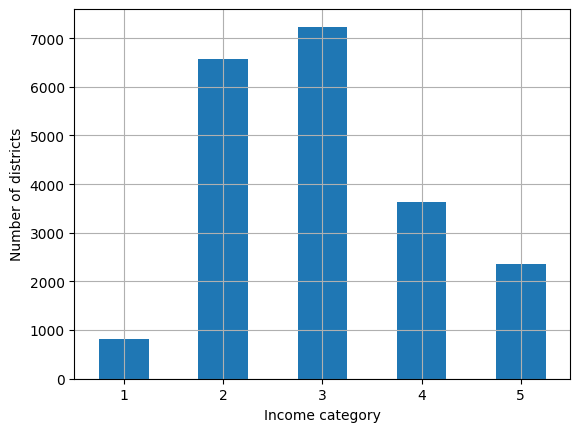

In [168]:
import matplotlib.pyplot as plt

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

다음 코드는 stratified split 생성을 10번 반복 수행하는 코드. 즉, 전체 데이터셋으로부터 서로 다른 10개의 (strat_train_set_n, strat_test_set_n)이 생성됩니다.


In [169]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

위에서 랜덤 샘플링을 위해 사용했던 train_test_split() 함수를 통해서도 stratified sampling 이 가능합니다.

stratify=housing["income_cat"] 키워드 인자 활용합니다.

In [170]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [171]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [172]:
housing = strat_train_set.copy()

원본 훈련셋으로 돌아간 후 타겟을 분리합니다.

In [173]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [174]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

데이터 정제해줍니다.

In [175]:
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [176]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [177]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [178]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16344x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16344 stored elements in Compressed Sparse Row format>

In [179]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [180]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [181]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [182]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [183]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) 

In [184]:
"""
문제 1에 대해 주어진 코드
"""
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa140ff67d0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

그리드 탐색을 통해 찾은 최적의 하이퍼 파라미터 조합입니다.

In [185]:
grid_search.best_params_

{'svr__C': 30.0, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}

최적의 하이퍼파라미터 조합일 때 SVM regressor모델의 RMSE입니다.

In [186]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

119791.51109743048

In [187]:
"""
문제 2에 대해 주어진 코드
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': reciprocal(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

"""
Randomized Search 설정: n_iter=20, cv=3, random_state=42 로 설정할 것
"""
rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=20, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7fa140ff67d0>)])),
                                             ('svr', SVR())]),
                   n_iter=20,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa1465b4400>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa14645ace0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

랜덤 탐색을 통해 찾은 최적의 하이퍼파라미터 조합입니다.

In [188]:
rnd_search.best_params_

{'svr__C': 24.17508294611391,
 'svr__gamma': 3.503557475158312,
 'svr__kernel': 'rbf'}

최적의 하이퍼파라미터 조합일 때 SVM regressor 모델의 RMSE입니다.

In [189]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

119801.39258436166

In [190]:
"""
문제 3에 대해 주어진 코드
"""
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    # 주어진 요구사항 만족하도록 fit()에 코드 추가
    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    # def inverse_transform(self, X):
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X

    # def get_feature_names_out(self, input_features=None):
    def get_feature_names_out(self, input_features=None):
      if input_features is None:
          return getattr(self, "feature_names_in_",
                          [f"x{i}" for i in range(self.n_features_in_)])
      else:
          if len(input_features) != self.n_features_in_:
              raise ValueError("Invalid number of features")
          if hasattr(self, "feature_names_in_") and not np.all(
              self.feature_names_in_ == input_features
          ):
              raise ValueError("input_features ≠ feature_names_in_")
          return input_features

In [191]:
from sklearn.utils.estimator_checks import check_estimator

# StandardScalerClone 커스텀 변환기 클래스가 scikit-learn convention에 맞게 구현되었는지 확인
check_estimator(StandardScalerClone())

In [192]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

In [193]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

In [194]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

In [195]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

In [196]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])